#Visualising Artistic Textures with CNNs

Artistic styles possess unique visual patterns, colors, and textures that are identifiable by Convolutional Neural Networks (CNNs). This work intends to present a Grad-CAM-based visualization method to emphasize the features learned by the model upon processing artistic images.

*   We used a ResNet18 model trained to classify artistic styles.
*   We applied Grad-CAM on multiple convolutional layers to get a comprehensive activation map.
*   We visualize feature maps and Grad-CAM overlays to interpret the model’s decision-making.

Before running the code,we make sure that we have the necessary dependencies installed:

In [ ]:
!pip install torch torchvision torchaudio tensorflow keras opencv-python matplotlib numpy seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install pdf2image

In [ ]:
!apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.6 [186 kB]
Fetched 186 kB in 0s (1,084 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 125044 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.6_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.6) ...
Setting up poppler-utils (22.02.0-2ubuntu0.6) ...
Processing triggers for man-db (2.10.2-1) ...


in the they asked us to choose 20+ images from the company - since I couldnt do that i extracted from the catalogue from their site-all images used here are from there only


In [ ]:
from pdf2image import convert_from_path
import os

pdf_path = "/content/extracted_images_only_removed.pdf"
output_dir = "/content/extracted_images"
os.makedirs(output_dir, exist_ok=True)

# Convert PDF pages to images
images = convert_from_path(pdf_path)

# Save images
for i, img in enumerate(images):
    img.save(os.path.join(output_dir, f"image_{i+1}.jpg"), "JPEG")

print("✅ Images extracted successfully!")

✅ Images extracted successfully!


The input imageso are resized and normalized before passing them to the model and I performed data-augmentation using transformers to prepare the dataset

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class ArtisticDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_files = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        label = idx % 2

        if self.transform:
            image = self.transform(image)

        return image, label

# Load dataset with augmentation
image_folder = "/content/extracted_images"
dataset = ArtisticDataset(image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [ ]:
print("✅ Dataloader Size:", len(dataloader))

✅ Dataloader Size: 4


In [ ]:
from google.colab import files
files.download("/content/model_epoch_10.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The code below is used for training the CNN model while simultaneously tracking and storing performance metrics (loss & accuracy) for each epoch,
we used this code to:
*   To Train the Model Over Multiple Epochs:  The loop runs for num_epochs = 10, meaning the model will be trained for 10 iterations over the dataset.
            
*   To Optimize the Model’s Weights
*    To Track Performance (Loss & Accuracy) Over Time
epochs, losses, and accuracies store values so we can visualize trends later.
*   To Print Epoch-wise Training Progress

Loss should decrease as training progresses.
Accuracy should increase, showing the model is learning.



In [ ]:
# Initialize lists for storing loss and accuracy
epochs = []
losses = []
accuracies = []
num_epochs=10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    # Store values for plotting
    epochs.append(epoch + 1)
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print(f"✅ Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


✅ Epoch 1/10, Loss: 0.4994, Accuracy: 0.7200


100%|██████████| 4/4 [00:07<00:00,  1.88s/it]


✅ Epoch 2/10, Loss: 0.4489, Accuracy: 0.7600


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


✅ Epoch 3/10, Loss: 0.3937, Accuracy: 0.8000


100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


✅ Epoch 4/10, Loss: 0.4443, Accuracy: 0.7600


100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


✅ Epoch 5/10, Loss: 0.8162, Accuracy: 0.8800


100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


✅ Epoch 6/10, Loss: 0.4138, Accuracy: 0.8000


100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


✅ Epoch 7/10, Loss: 0.4507, Accuracy: 0.8000


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


✅ Epoch 8/10, Loss: 0.7274, Accuracy: 0.7600


100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


✅ Epoch 9/10, Loss: 0.3618, Accuracy: 0.8800


100%|██████████| 4/4 [00:08<00:00,  2.02s/it]

✅ Epoch 10/10, Loss: 0.5785, Accuracy: 0.9200


In [ ]:
print("Epochs length:", len(epochs))
print("Losses length:", len(losses))

Epochs length: 10
Losses length: 10


the visualisation of loss and accuracy graphs


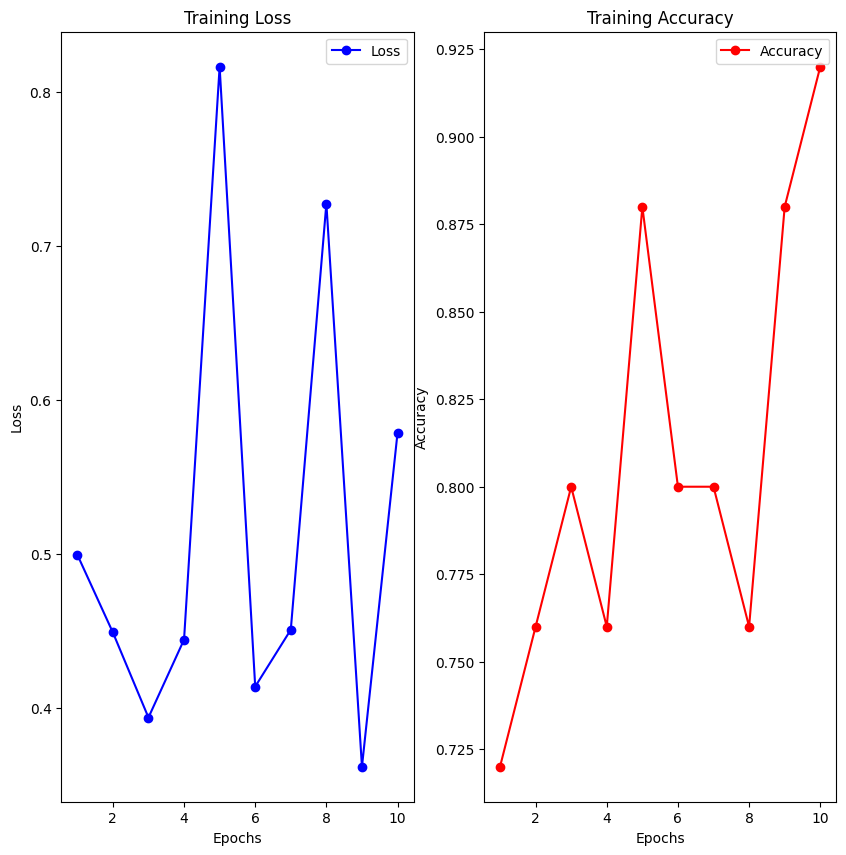

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# ✅ Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label="Loss", color="blue", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# ✅ Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label="Accuracy", color="red", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.show()


In [ ]:
import os

image_folder = "/content/extracted_images"  # Update if images are stored elsewhere

if os.path.isdir(image_folder):
    print("✅ Image directory exists. Listing available images:")
    print(os.listdir(image_folder))  # Show all image files
else:
    print("❌ ERROR: Directory does not exist! Check the image path.")


✅ Image directory exists. Listing available images:
['image_3.jpg', 'image_2.jpg', 'image_16.jpg', 'image_11.jpg', 'image_19.jpg', 'image_10.jpg', 'image_1.jpg', 'image_23.jpg', 'image_20.jpg', 'image_24.jpg', 'image_9.jpg', 'image_5.jpg', 'image_13.jpg', 'image_21.jpg', 'image_15.jpg', 'image_25.jpg', 'image_18.jpg', 'image_6.jpg', 'image_4.jpg', 'image_17.jpg', 'image_12.jpg', 'image_7.jpg', 'image_14.jpg', 'image_8.jpg', 'image_22.jpg']


In [ ]:
image_path = "/content/extracted_images/image_1.jpg"

We loaded a ResNet18 model and fine-tuned it for two artistic styles.

The input images need are resized and normalized before passing them to the model.

CNNs extract hierarchical features at different layers. So that we can  visualize feature maps from a selected convolutional layer.

Grad-CAM highlights important image regions that influence the model’s prediction. Instead of using just one layer, we use multiple convolutional layers for better interpretability.

Do you want to use your own image? (yes/no): yes
Enter the full path of your image: /content/extracted_images/image_15.jpg


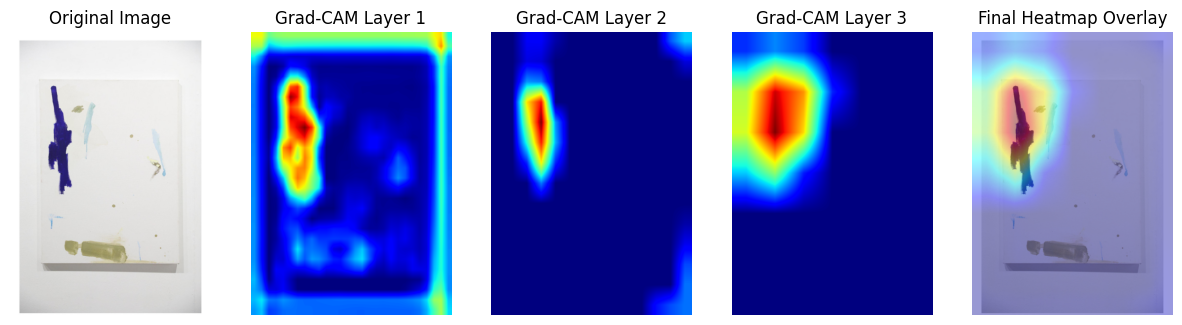

✅ Grad-CAM output generated successfully!


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

# ✅ Load Model
model_path = "/content/model_epoch_10.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ ERROR: Model checkpoint not found at {model_path}")

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# ✅ Preprocessing Function
def preprocess_image(image_path):
    """Loads and preprocesses an image for model inference."""
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    return transform(image).unsqueeze(0), np.array(image)

# ✅ Grad-CAM for Multiple Layers Simultaneously
def generate_combined_grad_cam(image_path, model, layers):
    """Computes Grad-CAM using multiple convolutional layers simultaneously and combines their heatmaps."""
    image_tensor, original_image = preprocess_image(image_path)

    gradients = {}
    activations = {}

    def forward_hook(module, inp, out):
        activations[module] = out

    def backward_hook(module, grad_in, grad_out):
        gradients[module] = grad_out[0]

    # Register hooks for all layers
    handles = []
    for layer in layers:
        handles.append(layer.register_forward_hook(forward_hook))
        handles.append(layer.register_backward_hook(backward_hook))

    # Forward pass
    output = model(image_tensor)
    class_idx = torch.argmax(output, dim=1).item()

    # Backward pass
    model.zero_grad()
    output[0, class_idx].backward()

    # Compute Grad-CAM for each layer
    cams = []
    for layer in layers:
        act = activations[layer].cpu().detach().numpy()
        grad = gradients[layer].cpu().detach().numpy()
        weights = np.mean(grad, axis=(2, 3))

        # Compute Grad-CAM
        layer_cam = np.zeros(act.shape[2:], dtype=np.float32)
        for i in range(act.shape[1]):
            layer_cam += weights[0, i] * act[0, i, :, :]
        layer_cam = np.maximum(layer_cam, 0)  # ReLU

        # Resize to original image size
        layer_cam = cv2.resize(layer_cam, (original_image.shape[1], original_image.shape[0]))
        cams.append(layer_cam)

    # Combine multiple Grad-CAM maps
    combined_cam = np.mean(np.array(cams), axis=0)

    # Normalize and apply heatmap
    combined_cam = (combined_cam - np.min(combined_cam)) / (np.max(combined_cam) + 1e-10)
    heatmap = cv2.applyColorMap(np.uint8(255 * combined_cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)

    #  Visualization: Show Individual Layer Heatmaps
    fig, axes = plt.subplots(1, len(cams) + 2, figsize=(15, 5))

    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    for i, cam in enumerate(cams):
        axes[i + 1].imshow(cam, cmap="jet")
        axes[i + 1].set_title(f"Grad-CAM Layer {i+1}")
        axes[i + 1].axis("off")

    axes[-1].imshow(superimposed_img)
    axes[-1].set_title("Final Heatmap Overlay")
    axes[-1].axis("off")

    plt.show()
    return superimposed_img

#  Select Custom Image OR Use Image 11
def get_image():
    use_custom = input("Do you want to use your own image? (yes/no): ").strip().lower()

    if use_custom == "yes":
        custom_image_path = input("Enter the full path of your image: ").strip()
        if not os.path.exists(custom_image_path):
            raise FileNotFoundError(f" ERROR: The file {custom_image_path} does not exist.")
        return custom_image_path
    else:
        image_folder = "/content/extracted_images"
        available_images = sorted(os.listdir(image_folder))

        if len(available_images) >= 11:
            image_path = os.path.join(image_folder, available_images[10])
            print(f" Using Image 11: {image_path}")
        else:
            image_path = os.path.join(image_folder, available_images[0])
            print(f" Image 11 not found. Using first available image: {image_path}")

        return image_path

# Run Grad-CAM
image_path = get_image()

# 🔹 Use Multiple Layers for Grad-CAM Simultaneously
target_layers = [model.layer2[1].conv2, model.layer3[1].conv2, model.layer4[1].conv2]
generate_combined_grad_cam(image_path, model, target_layers)

print(f" Grad-CAM output generated successfully!")


so basically the problem with this is concentration of different layers works in different images so i tried to create a generalised layer model which does Grad-Cam for multiple layers simultaneously


#In Conclusion
 This project demonstrates CNN-based artistic feature visualization using Grad-CAM. By using multiple layers, we obtain a more informative heatmap that reveals which regions of an artwork are most influential in the model’s classification.


Next Steps:
*   Train the model on a larger dataset of artistic styles.
*   Fine-tune the network for better accuracy.
*   Compare Grad-CAM with other interpretability methods.

